# Demo notebook for respiratory phase alignment tests

Introduces basic functions of library for processing respiration recordings (single best chest stretch).

https://pypi.org/project/respy/0.1.1/

    pip install respy

using respy and activity analysis. Activity analysis explained in:
    
    Upham, F., & McAdams, S. (2018). Activity analysis and coordination in continuous responses to music. Music Perception: An Interdisciplinary Journal, 35(3), 253-294.


In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

from respy import respy
from respy import act

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Demonstration of concurrent respiration recordings from repeated response experiment with case study participant, Joan (Upham, 2018), as she listenned to an a capella performances of a french canadian folk song.

These respiration traces were measured with Thought Technology respiration belt and sampled at 20 Hz. 

In [2]:
data_loc = './demo_data/'

RespRecs = pd.read_csv(data_loc + 'P2_listenings_Rosier.csv',index_col = 0)


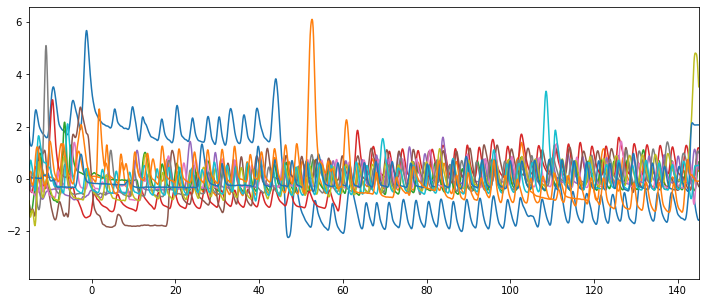

In [3]:
RespNorm = RespRecs.copy()
listenings = RespRecs.columns
for part in listenings:
    # gather statistics on breath shapes in original stretch unites across both sessions
    sig = RespRecs.loc[:,part]
    br = respy.Breath_Features(sig,scalingfactor=1)
    # normalised each sessions resp recording according to statistics across the two
    newSig=respy.respnormed(sig,scaling=1/br['Depth'].median())
    RespNorm.loc[:,part]=newSig.iloc[:,0]
RespNorm.plot(figsize=(12,5),legend=False)
plt.xlim([-15,145]) 
plt.show()

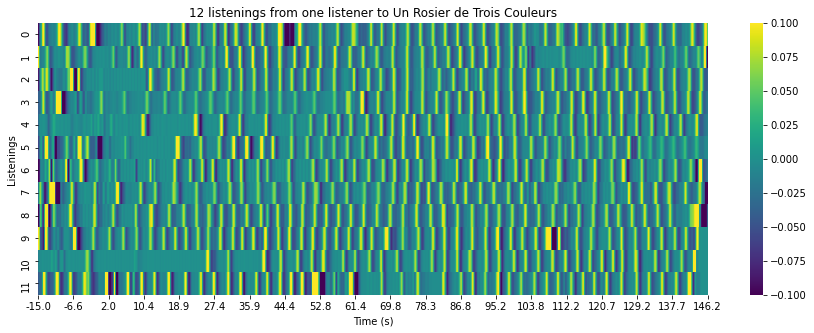

In [4]:
fig, (ax) = plt.subplots(1, 1,figsize = [15,5])

df_sig = RespNorm.diff().copy()
chart = sns.heatmap(data=df_sig.transpose(),vmin=-0.1, vmax=0.1, ax=ax,cmap="viridis")

#compensate for heatmap terrible xtick labels
times = df_sig.index
num_ticks = 20
xticks = np.linspace(0, len(times) - 1, num_ticks, dtype='int')
xticklabels = [np.round(times[idx],1) for idx in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation = 0)

ax.set_ylabel('Listenings')
ax.set_title('12 listenings from one listener to Un Rosier de Trois Couleurs')
ax.set_xlabel('Time (s)')
plt.savefig('./plots/Full_Scaled_Resp_aligned.png',dpi = 300)
plt.show()


The differences respiration sequences plot suggests there are moments of where respiration tends to align with specific phases. We can evaluate if and when phase components are aligned to the music through their coordination with each other.

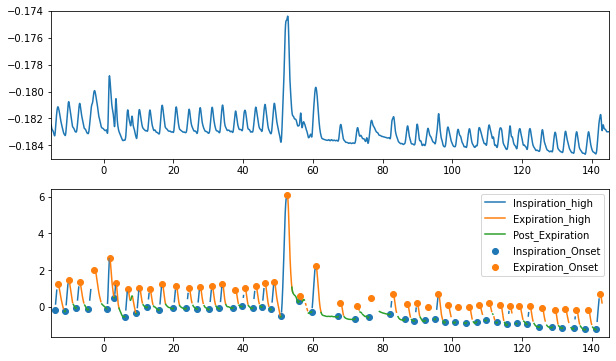

In [5]:
respPhases = respy.Resp_phases(RespNorm['11'], 0.7, 0.3)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(211)
sig.plot(ax=ax)
plt.ylim([-0.185,-0.174])
plt.xlim([-15,145]) 
ax = fig.add_subplot(212)
# respPhases[Comps].plot(ax=ax)
CP = respPhases.loc[respPhases['Inspiration_Onset']==1,'Signal']
ax.scatter(x = CP.index,y = CP.values,label = 'Inspiration_Onset')
respPhases['Inspiration_high'].plot(ax=ax)
CP = respPhases.loc[respPhases['Expiration_Onset']==1,'Signal']
ax.scatter(x = CP.index,y = CP.values,label = 'Expiration_Onset')
respPhases['Expiration_high'].plot(ax=ax)
respPhases['Post_Expiration'].plot(ax=ax)

plt.legend()
plt.xlim([-15,145]) 
plt.savefig('./plots/phase_components_2.png',dpi = 400)

plt.show()

## Quantify alignment in specific phase components

Activity analysis (act) is a statistics library designed to evaluate the quality of coincidence of a single type of event across concurrent time series. It is non-parametric and has been tested for false positive rates on these common respiratory phase components during music listening. 

The window for coincidence for respiratory phase component is set according to the type of respiration (quiet or active), weither the phase component is instantaneous (onsets) or an interval (high or low flow). The window sizes below were evaluated for reliability in detecting coincidences across repeated listenings to music (not-active). 

In [6]:
Comps = ['Inspiration_Onset', 'Expiration_Onset', 'Inspiration_high',
       'Expiration_high','Post_Expiration']
windows = {'Inspiration_Onset':0.5, 'Expiration_Onset':0.5, 'Inspiration_high':0.2,
       'Expiration_high':0.2,'Post_Expiration':0.2}


The following cell evaluates the respiratory phase components of each listenings and then tests each phase components separately. 

In [8]:
df = RespNorm.copy()
scale_high = 0.7
scale_low = 0.3
part = df.columns
V=[]
for j in range(len(Comps)):
    d_phC = pd.DataFrame(index = df.index)
    V.append(d_phC)
    
for i in range(len(part)):
    p = part[i]
    p_phases = respy.Resp_phases(df[p],scale_high, scale_low)
    for j in range(len(Comps)):
        component = Comps[j] #= 'Post_Expiration'
        d_phC = V[j]
        v = p_phases[component]
        v.loc[v.notna()] = 1
        v.loc[v.isna()] = 0
        d_phC[i] = v.values # can't have column names in current activity analysis :/
W = []
for j in range(len(Comps)):
    component = Comps[j]
    d_phC = V[j]
    d_trimed = respy.trimAct(d_phC)
    W.append(d_trimed)

Evaluation of coincidences in respiration components produces a coordination score for the full concurrent interval(Upham & McAdams, 2018). Values under 2.0 indicate that 1% of non-parameteric alternative alignments were more coincident than the original timing of these measurements. 

If this global measure of concidence for a phase exceeds the alpha thresold (here 0.05), the moments of extreme local coincidence (high and low concentrations of this phase component) are marked in red. If the alignment across recordings doesn't pass threshold in this non-parametric test of coincidence, extreme coincidence time points are marked in pale yellow. 

34.319884061813354
67.65414714813232
97.13401699066162
126.88287830352783
155.32220220565796


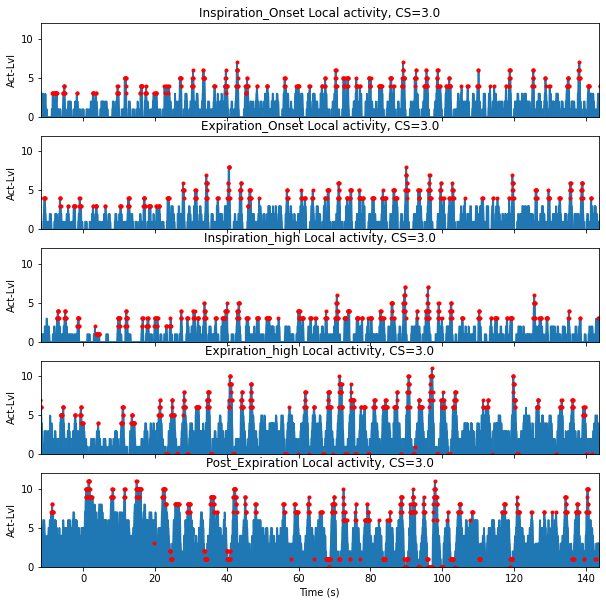

In [9]:
ShuffleRange = 10
Iter = 1000
alpha = 0.05
tic = time.time()
Z = []

fig, axs = plt.subplots(5,1, sharex='all',figsize=(10,10))

for j in range(len(Comps)):
    component = Comps[j]
    d_trimed = W[j]
    FrameSize = windows[component]
    stest = act.localActivityTest(d_trimed,FrameSize,ShuffleRange,Iter,alpha)
    Z.append(stest)
    
    A = stest['MeasuredResults']
    B = stest['ActivityPeaks']
    # plot the activity levels with local activity peaks
    A['Activity-levels'].plot.area(ax=axs[j])
    B['Activity-levels'].plot(style='r.',ax=axs[j])
    
    axs[j].set_ylim(0,12)
    axs[j].set_xlim(A.index[0],A.index[-1])
    axs[j].set_ylabel('Act-Lvl')
    
    axs[j].set_title(component + ' Local activity, CS='+str(round(stest['CoordScore'],3)))
    print(time.time()-tic)

axs[j].set_xlabel('Time (s)')
plt.savefig('./plots/Phase_alignment_example.png',dpi = 300)

plt.show()

This non parametric test of local coincidence for each phase can take sometime. Many minutes of calculations for a few minutes of music, depending on the number of respiration recordings assessed concurrently, sample rates, etc. Be prepared to wait.

The plots here show that there is remarkably high coincidence in all phases evaluated, but the local activity helps identify when individual componenets are remarkably concentrated. These moments points back to the shared stimulus for explanations. 